# 探索ptt汽車版對於「電動車」之相關議題與社群輿論分析

**Group:** 4<br>
**Author:** 董庭妤 翁忠宇 林佳融 姚慕東<br>
**Date created:** 2023/04/12<br>
**Last modified:** 2023/06/05<br><br>
**網址** https://www.youtube.com/watch?v=Lz5ZciPFRKw

<h2>研究動機</h2>
近年來，電動車議題在社群網路上引起了極大的關注，不論是關於電動車自動駕駛的積極討論，還是對於意外事件的負面情緒，都對電動車的討論數量產生了重要影響。

我們收集PTT上關於電動車的討論文章和評論，並運用情緒分析判斷用戶對於特定主題的情感、利用主題模型，將討論文章和評論歸類到不同的主題類別，最後畫出資料的社群網路圖。
透過分析不同用戶的情緒傾向和參與的主題類別，我們可以深入了解用戶在社群網路中的立場和興趣。

最終，本研究希望能找出不同用戶與電動車議題之間的關係，並提供對於電動車社群網路互動的關係。了解這些關係可以有助於幫助我們找出電動車議題的重要因素，提供日後分析使用。




In [1]:
from datetime import datetime
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from wordcloud import WordCloud
from nltk import ngrams
from nltk import FreqDist
import jieba
import networkx as nx
import math
%matplotlib inline

In [2]:
# plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
fprop = fm.FontProperties(fname="./SourceHanSansTW-Regular.otf")
fprop


# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

## 資料前處理
使用「電動車」作為關鍵字，從工作流程系統中將 ptt 資料下載下來

### 基本資料介紹
- 資料來源: 工作流程蒐集PTT 汽車版 Car 2022-04-01 ~ 2023-04-15 所有文章

In [3]:
df = pd.read_csv("./car.csv")
df = df.rename(columns={"artContent": "sentence"})
df.head()

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/car/M.1648778137.A.72B....   
1          2  https://www.ptt.cc/bbs/car/M.1648821343.A.2E5....   
2          3  https://www.ptt.cc/bbs/car/M.1648894717.A.DDC....   
3          4  https://www.ptt.cc/bbs/car/M.1648907890.A.C6F....   
4          5  https://www.ptt.cc/bbs/car/M.1648953237.A.DDB....   

                  artTitle              artDate  artPoster artCatagory  \
0  [受訪]電動汽車充電行為與使用研究(徵受訪者)  2022-04-01 09:55:34      edian         car   
1      [電車]model31年半4萬公里花費  2022-04-01 21:55:39   mk203125         car   
2    Re:[討論]為什麼Model3越賣越好？  2022-04-02 18:18:33     asdhse         car   
3        [新聞]原材料短缺德國汽車產業驚恐  2022-04-02 21:58:07  yamatobar         car   
4        [問題]XC90退休後的通勤車選擇  2022-04-03 10:33:55  morrislek         car   

                                            sentence  \
0  本文經Munezsu板主核准\n各位Car版的版友好，\n\n我們是\nBLD\nEnerg...   
1  人生第一台車\n\n本來滿一年時想發個心得(花費)才發現第一年連保養里程都不到\n\n透天+...   
2  發這文，你後悔了嗎？\n現在入門要174萬惹，自從真特黑和假特粉都下去後，就沒有人可以阻止特...   
3  原文連結：\nhttps://reurl.cc/xOyGoN\n原文內容：\n\n（德國之聲...   
4  家裏的XC90（2018年式）即將屆滿五年，每日通勤車，目前里程數將近20萬公里，預計保固內...   

                                          artComment             e_ip  \
0                                                 []   61.227.169.165   
1  [{"cmtStatus": "推", "cmtPoster": "wuii0306", "...      1.34.96.153   
2  [{"cmtStatus": "推", "cmtPoster": "ISNAKEI", "c...  114.137.122.238   
3  [{"cmtStatus": "推", "cmtPoster": "iwei0930", "...   114.24.105.175   
4  [{"cmtStatus": "推", "cmtPoster": "Lowpapa", "c...   118.169.86.172   

          insertedDate dataSource  
0  2022-04-02 00:06:23        ptt  
1  2022-04-02 00:06:29        ptt  
2  2022-04-02 23:29:31        ptt  
3  2022-04-02 23:29:33        ptt  
4  2022-04-04 01:05:43        ptt

In [4]:
clear_df = df.copy()

# 去除有包含空值的筆數
clear_df.dropna(axis=0, how="any", inplace=True)

# 用'。'取代'\n\n'，並移除'\n'
clear_df = clear_df.replace("\\n\\n", "。", regex=True).replace("\n", "", regex=True)

# 移除內文中的網址
clear_df["sentence"] = (
    clear_df["sentence"]
    .replace(r"http\S+", "", regex=True)
    .replace(r"www\S+", "", regex=True)
    .replace(r"\d+", "", regex=True)
)

In [5]:
clear_df["sentence"] = clear_df["sentence"].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode("sentence").reset_index(drop=True)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

In [6]:
jieba.set_dictionary("dict/dict.txt")
jieba.load_userdict("dict/user_dict.txt")

Building prefix dict from c:\Users\Modern 14\Desktop\SMA_G4project\SMA_G4project\20230605\dict\dict.txt ...
Dumping model to file cache C:\Users\MODERN~1\AppData\Local\Temp\jieba.u802bdb60760298ed0c9090505bd454e3.cache
Loading model cost 1.294 seconds.
Prefix dict has been built successfully.


In [7]:
sent_df["sentence"] = (
    sent_df["sentence"].str.replace(r"[^\w\s\d]+", "", regex=True).astype(str)
)
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

In [8]:
word_df = (
    sent_df.assign(word=sent_df["sentence"].apply(jieba.lcut))
    .explode("word")
    .drop(["sentence"], axis=1)
)
word_df = word_df.loc[word_df["word"].str.len() > 1]

In [9]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [
    line.strip()
    for line in open("dict/stopwords.txt", "r", encoding="utf-8").readlines()
]

In [10]:
noStop_df = word_df[~word_df["word"].isin(stopwords)]

In [11]:
noStop_df["word"].value_counts().to_csv("./freq.csv")

## lexicon-base 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 準備LIWC字典  

In [12]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

word sentiments
0   ):     affect
1   3q     affect
2   :(     affect
3   :)     affect
4   <3     affect

In [13]:
liwc_dict['sentiments'].value_counts()

sentiments
affect      2061
negative    1172
positive     730
anger        358
sad          192
anx          169
Name: count, dtype: int64

In [14]:
ptt_df = noStop_df.copy()
ptt_df["artDate"] = pd.to_datetime(ptt_df["artDate"])

In [15]:
# ptt_df["artDate"].describe()

TypeError: describe() got an unexpected keyword argument 'datetime_is_numeric'

In [16]:
ptt_df["artDate"] = ptt_df["artDate"].dt.date

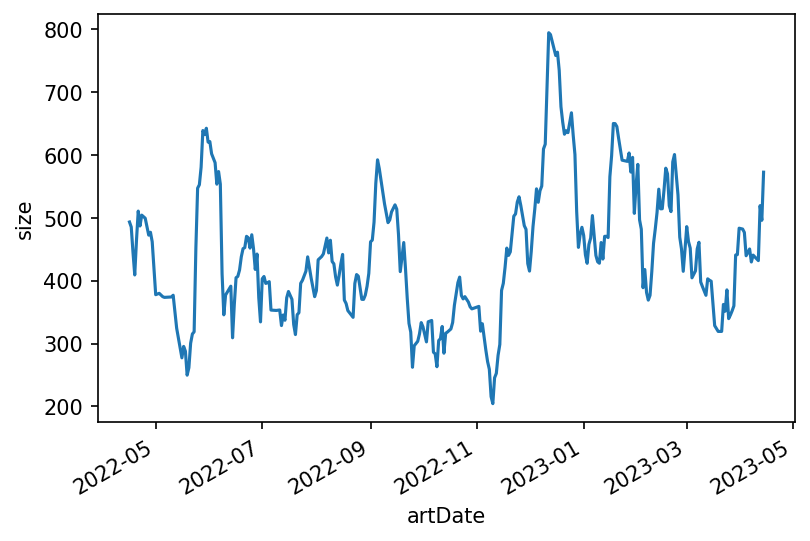

In [17]:
ptt_line_plot = ptt_df.groupby(["artDate"], as_index=False).size()

fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_line_plot["artDate"], ptt_line_plot["size"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel('size')
fig.autofmt_xdate()
plt.show()

可以看到 2022年12月發文量急遽增加。

### 情緒字典與斷詞結果進行合併

In [18]:
ptt_liwc_df = pd.merge(ptt_df[["artDate", "artUrl", "word"]], liwc_dict, how="left")
ptt_liwc_df

artDate                                             artUrl  \
0       2022-04-01  https://www.ptt.cc/bbs/car/M.1648778137.A.72B....   
1       2022-04-01  https://www.ptt.cc/bbs/car/M.1648778137.A.72B....   
2       2022-04-01  https://www.ptt.cc/bbs/car/M.1648778137.A.72B....   
3       2022-04-01  https://www.ptt.cc/bbs/car/M.1648778137.A.72B....   
4       2022-04-01  https://www.ptt.cc/bbs/car/M.1648778137.A.72B....   
...            ...                                                ...   
150977  2023-04-14  https://www.ptt.cc/bbs/car/M.1681476499.A.5E3....   
150978  2023-04-14  https://www.ptt.cc/bbs/car/M.1681476499.A.5E3....   
150979  2023-04-14  https://www.ptt.cc/bbs/car/M.1681476499.A.5E3....   
150980  2023-04-14  https://www.ptt.cc/bbs/car/M.1681476499.A.5E3....   
150981  2023-04-14  https://www.ptt.cc/bbs/car/M.1681476499.A.5E3....   

           word sentiments  
0            本文        NaN  
1       Munezsu        NaN  
2            板主        NaN  
3            核准        NaN  
4           Car        NaN  
...         ...        ...  
150977       北歐        NaN  
150978       抽到        NaN  
150979       荷蘭        NaN  
150980       最高        NaN  
150981       抽到        NaN  

[150982 rows x 4 columns]

### 1.一年內對電動車的情緒波動
14天平均or比例or每日?

分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [19]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"], dropna=False, as_index=False).size()
)
sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])

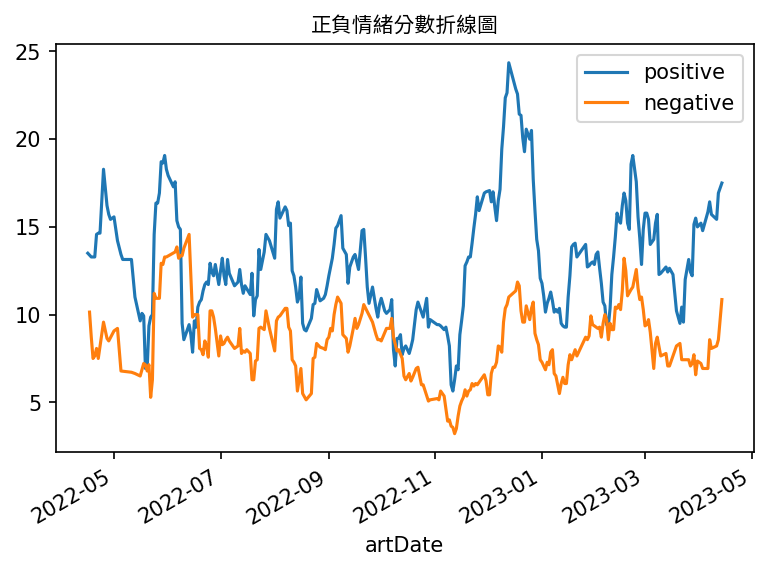

In [20]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天移動平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒分數折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

畫出每天的情緒總分數，可以看到通常正面的分數都會超過負面，但起伏還是很大，可見大家對電動車評價不一。

### 正負向情緒分數比例折線圖圖

In [21]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

artDate sentiments  size     ratio
0     2022-04-01     affect     6  0.042553
1     2022-04-01   positive     5  0.035461
2     2022-04-01        NaN   130  0.921986
3     2022-04-02     affect    32  0.046852
4     2022-04-02      anger     6  0.008785
...          ...        ...   ...       ...
1713  2023-04-14      anger     3  0.002017
1714  2023-04-14        anx     4  0.002690
1715  2023-04-14   negative    38  0.025555
1716  2023-04-14   positive    44  0.029590
1718  2023-04-14        NaN  1309  0.880296

[1719 rows x 4 columns]

In [22]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

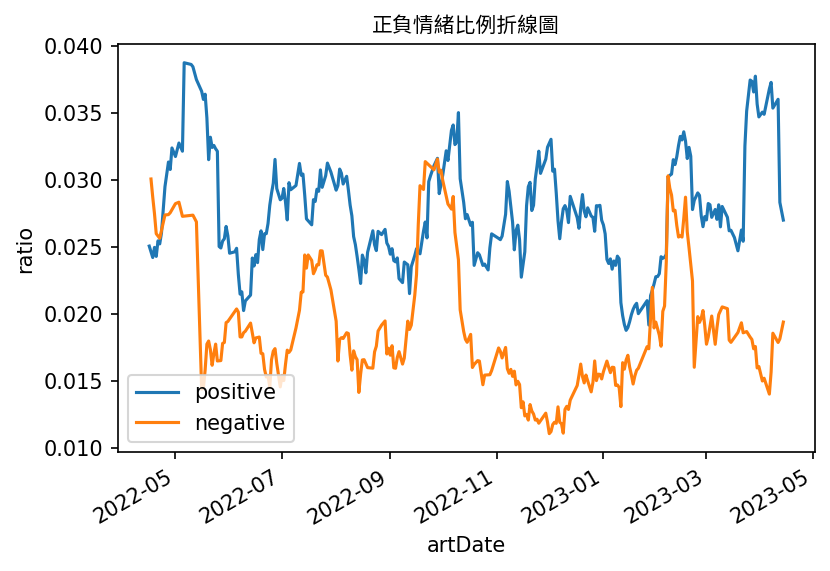

In [23]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

### 每日情緒分數趨勢

In [24]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

In [25]:
# sentiment 計算方式: positive - anger - anx - negative - sad
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["anger"]
    - ptt_sentiment_value["anx"]
    - ptt_sentiment_value["negative"]
    - ptt_sentiment_value["sad"]
)

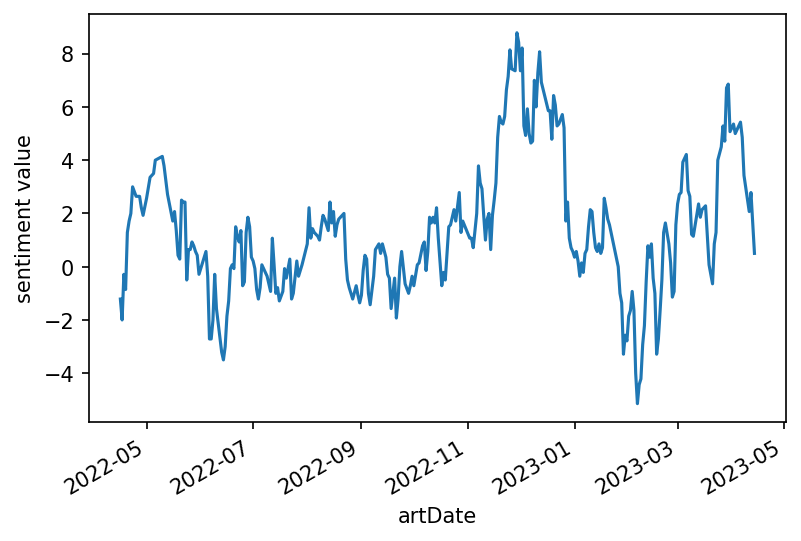

In [26]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()

2022年6月對於電動車的情緒較負面。

### 2. 一年內正負面情緒字

In [27]:
mask = (ptt_liwc_df["artDate"].notnull())
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

(-0.5, 399.5, 199.5, -0.5)

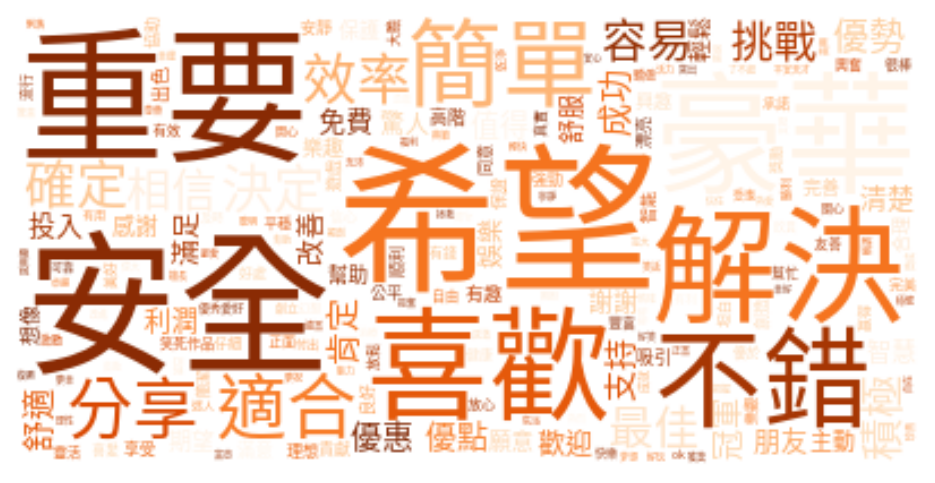

In [28]:
mask = (ptt_liwc_df["artDate"].notnull()) & (
    ptt_liwc_df["sentiments"] == "positive"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="Oranges")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

(-0.5, 399.5, 199.5, -0.5)

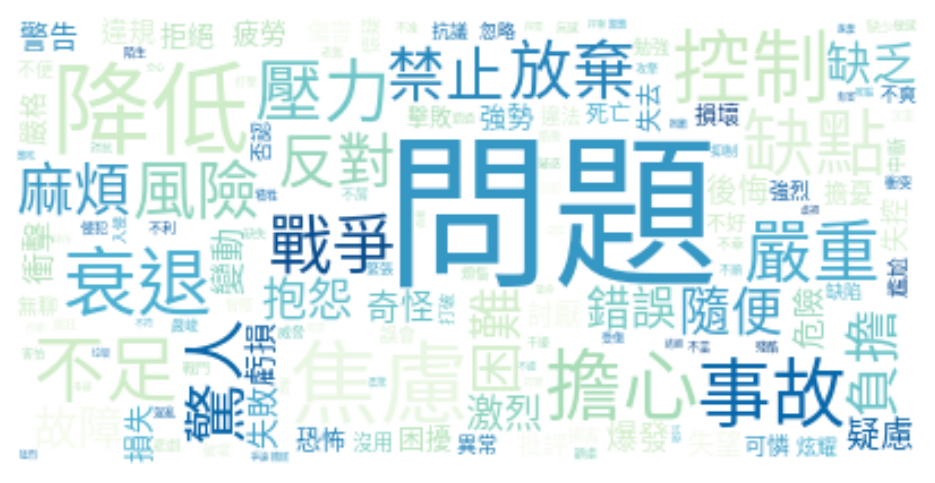

In [29]:
mask = (ptt_liwc_df["artDate"].notnull()) & (
    ptt_liwc_df["sentiments"] == "negative"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

### 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [30]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]

<ipython-input-31-2e3a42b1fcf0>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
<ipython-input-31-2e3a42b1fcf0>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

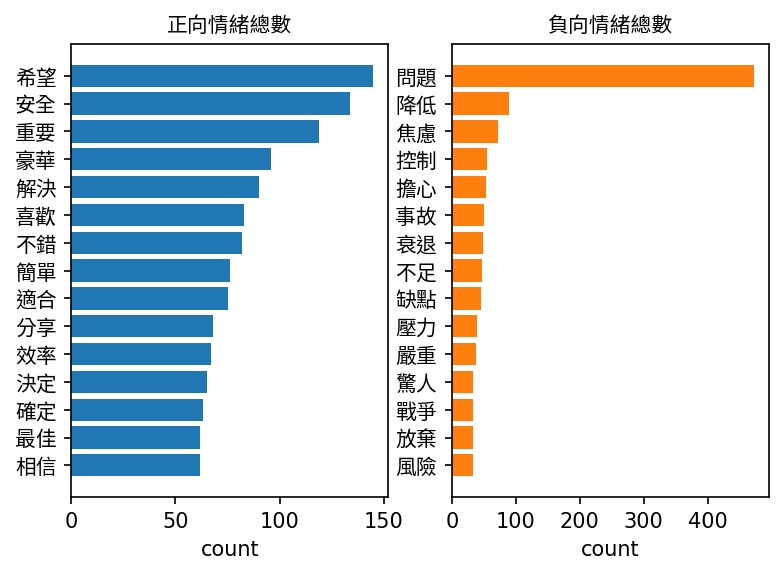

In [31]:
pos = word_of_pos.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]
neg = word_of_neg.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

從正向情緒得知，鄉民注重電動車的"安全"、"豪華"程度；同時也擔心電動車可能衍伸出的"問題"，進而感到"焦慮"。

透過結巴斷詞與N-gram幫助建立字典，了解什麼樣的功能是鄉民們在乎的以及其認為需要改善的

In [32]:
# 新增電動車相關自定義字典
jieba.load_userdict('./dict/car_lexicon.txt')

In [33]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [34]:
car_bigram = sent_df.copy()
car_bigram["word"] = car_bigram.sentence.apply(bigram_getToken_dict)
car_bigram = car_bigram.explode('word')

In [35]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

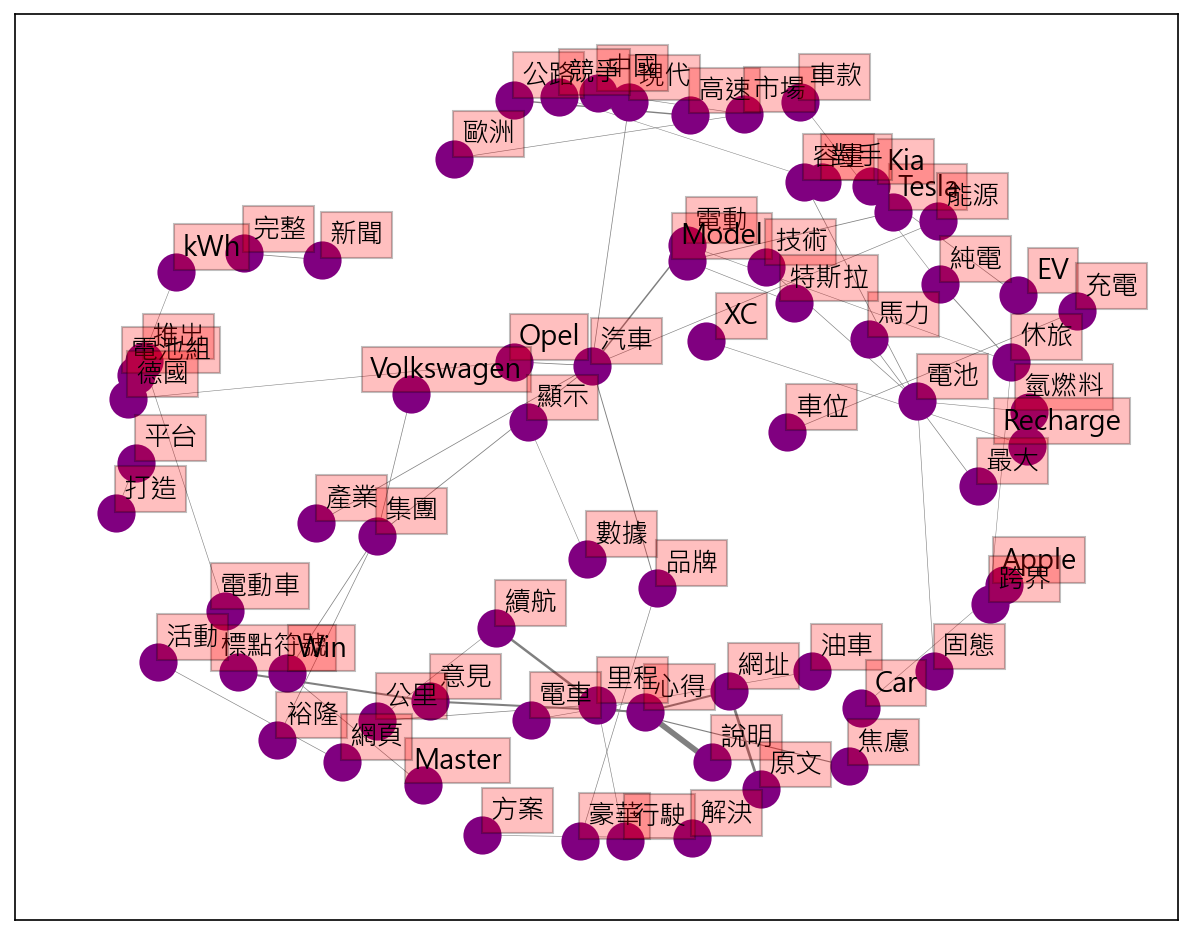

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

鄉民對於電動車"車款"、"電池"、"馬力"等關注度都很高

### 4. 探討特定月份造成對於電動車的情緒較低
2022年6月對於電動車的情緒較負面，分析常被討論的正負面情緒字。

In [37]:
mask = (ptt_liwc_df['artDate'].notnull())
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

(-0.5, 399.5, 199.5, -0.5)

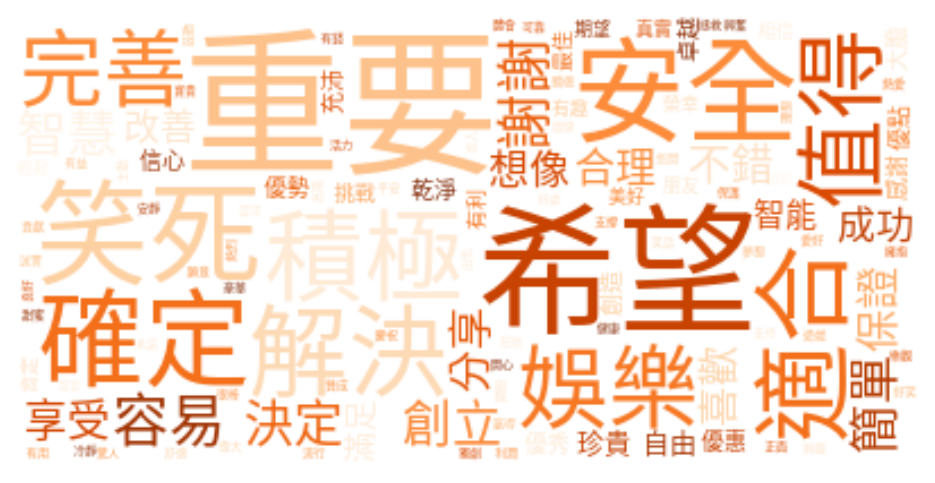

In [39]:
start_date = pd.Timestamp('2022-06-01').date()
end_date = pd.Timestamp('2022-06-30')
start_date, end_date = start_date.date(), end_date.date()
mask = (ptt_liwc_df['artDate'] >= start_date) & (
    ptt_liwc_df['artDate'] <= end_date) & (
    ptt_liwc_df["sentiments"] == "positive"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="Oranges")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

電動車的"安全"性、值不"值得"、"完善"程度等常被討論。

(-0.5, 399.5, 199.5, -0.5)

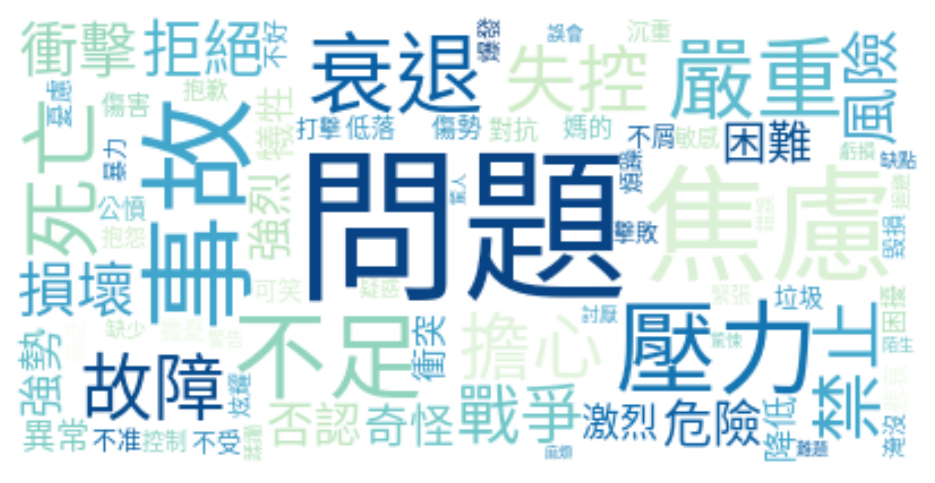

In [40]:
mask = (ptt_liwc_df['artDate'] >= start_date) & (
    ptt_liwc_df['artDate'] <= end_date) & (
    ptt_liwc_df["sentiments"] == "negative"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

電動車的"問題"、"事故"常令人們感到"壓力"和"焦慮"。

### 情緒代表字
從6月的文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [41]:
mask = (ptt_liwc_df['artDate'] >= start_date) & (
    ptt_liwc_df['artDate'] <= end_date) & (
    ptt_liwc_df["sentiments"].isin(['positive', 'negative'])
)

ptt_df_date = ptt_liwc_df.loc[mask, ["artDate", "word", "sentiments"]]
ptt_df_date_senti = ptt_df_date.groupby(["sentiments", "word"], as_index=False).size()

<ipython-input-42-a06535ac13d9>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
<ipython-input-42-a06535ac13d9>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


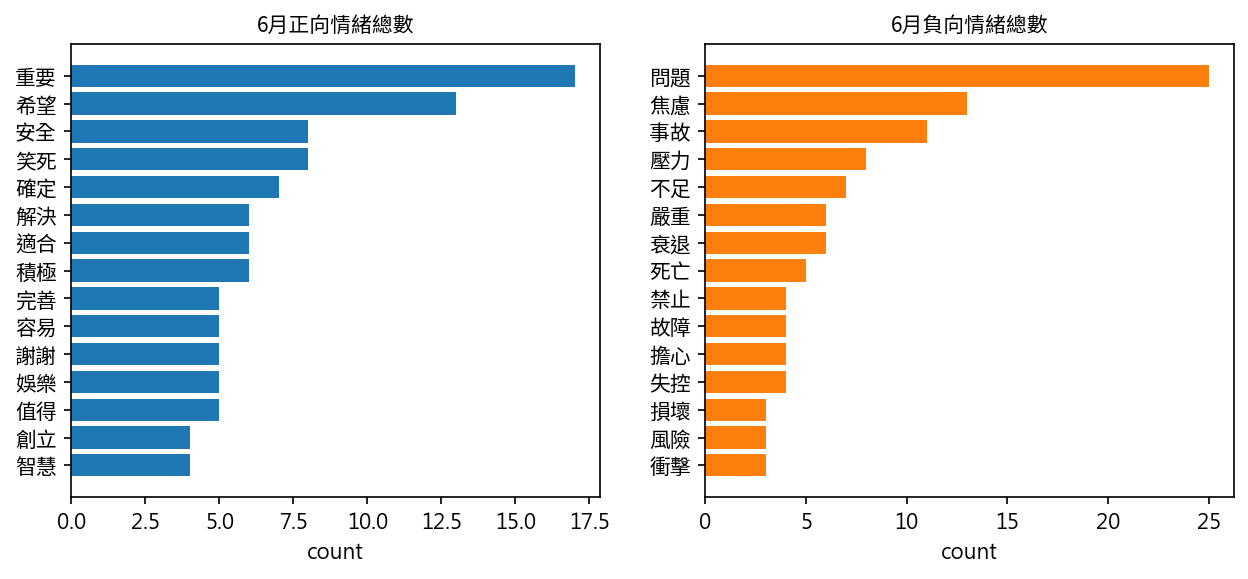

In [42]:
pos = ptt_df_date_senti[(ptt_df_date_senti["sentiments"] == "positive")].sort_values(
    ["size"], ascending=True
)
pos = pos[-15:]
neg = ptt_df_date_senti[ptt_df_date_senti["sentiments"] == "negative"].sort_values(
    ["size"], ascending=True
)
neg = neg[-15:]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_title(f"6月正向情緒總數", fontproperties=fprop)
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_title(f"6月負向情緒總數", fontproperties=fprop)
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
plt.show()

### 5. 探討特定月份前、當月、當月後關鍵字

2022年6月前

In [45]:
end_date = pd.Timestamp('2022-06-01').date()
# end_date = end_date.date()
mask = (ptt_liwc_df['artDate'] < end_date)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

(-0.5, 399.5, 199.5, -0.5)

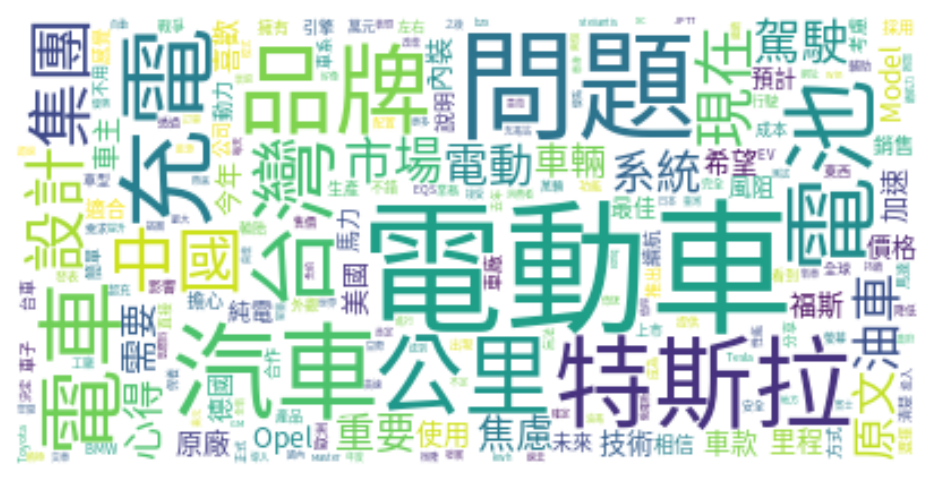

In [46]:
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

主要討論"充電"、"電池"、"問題"、"台灣"、"品牌"。

2022年6月

In [48]:
start_date = pd.Timestamp('2022-06-01').date()
end_date = pd.Timestamp('2022-06-30').date()
mask = (ptt_liwc_df['artDate'] >= start_date) & (
    ptt_liwc_df['artDate'] <= end_date)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

(-0.5, 399.5, 199.5, -0.5)

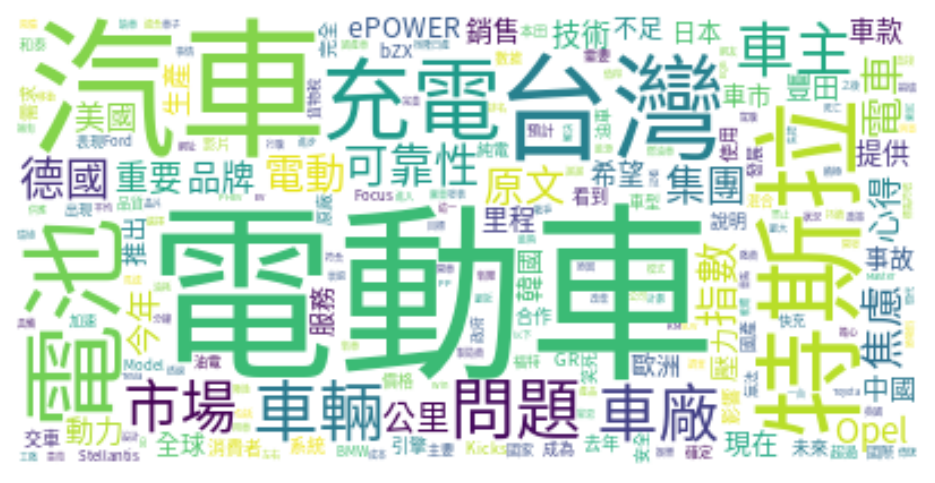

In [49]:
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

主要討論"充電"、"電池"、"台灣"、"特斯拉"、"車廠"。

2022年6月後

In [51]:
start_date = pd.Timestamp('2022-06-30').date()
mask = (ptt_liwc_df['artDate'] > start_date)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

(-0.5, 399.5, 199.5, -0.5)

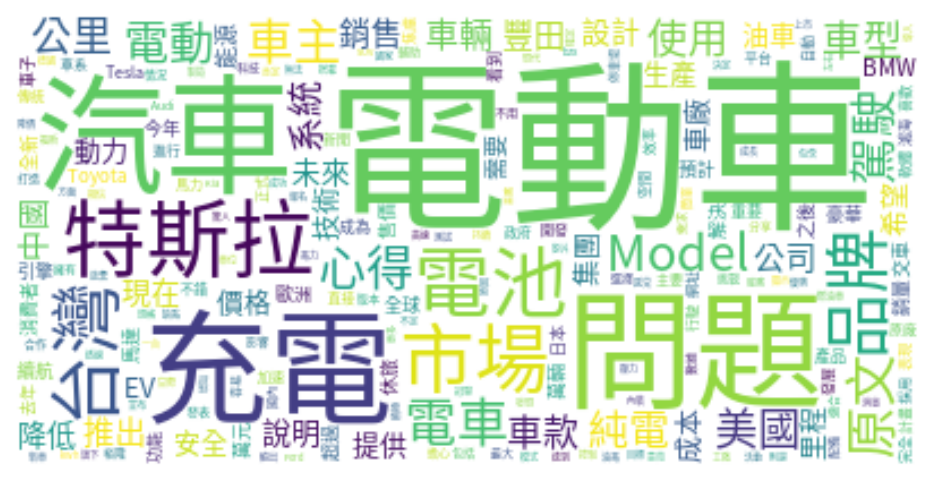

In [52]:
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

主要討論"特斯拉"、"充電"、"問題"、"電池"、"市場"。

### 7. 這些關鍵字和購買因素是否有相關（共線圖）

計算兩個詞彙間的相關性 Phi相關係數(Phi coefficient)  

In [53]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1] # 篩選掉停用字與字元數大於1的詞彙
    return seg_list
# 重新進行斷詞
data = sent_df.copy()
data['word'] = data.sentence.apply(getToken)
data = data.explode('word')

In [54]:
# 再次計算各詞彙在各文章中出現的次數
word_count = data.groupby(['artDate','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)

In [55]:
# 取常一起出現的bigram pair 前1500筆
b = {k:v for k,v in bigramfdist.most_common(1500)}
# 建立DataFrame
bigram_df = pd.DataFrame(list(b), columns=['word','word2']).assign(n=b.values())
#計算phi值
def phi_cor(df):
    # total x
    nx = len(set(word_count[word_count["word"]==df["word"]]["artDate"]))
    tnx = len(sent_df)-nx
    # total y
    ny = len(set(word_count[word_count["word"]==df["word2"]]["artDate"]))
    tny = len(sent_df)-ny
    # 有x 有y
    x_ls = list(word_count[word_count["word"]==df["word"]]["artDate"]) #單獨有x
    y_ls = list(word_count[word_count["word"]==df["word2"]]["artDate"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    # 有x 沒有y
    nxo = nx-nxy
    # 沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(sent_df["artDate"]))-uxy) #取差集:全-有x有y
    # 沒有x 有y
    noy = ny-nxy
    # print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

In [56]:
word_cors = bigram_df[bigram_df["cor"]>0.6]
word_cors.reset_index(inplace=True, drop=True)
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(word_cors)):
    g.add_edge(word_cors["word"][i], word_cors["word2"][i], weight=word_cors["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*10 for w in  g.edges(data=True)]

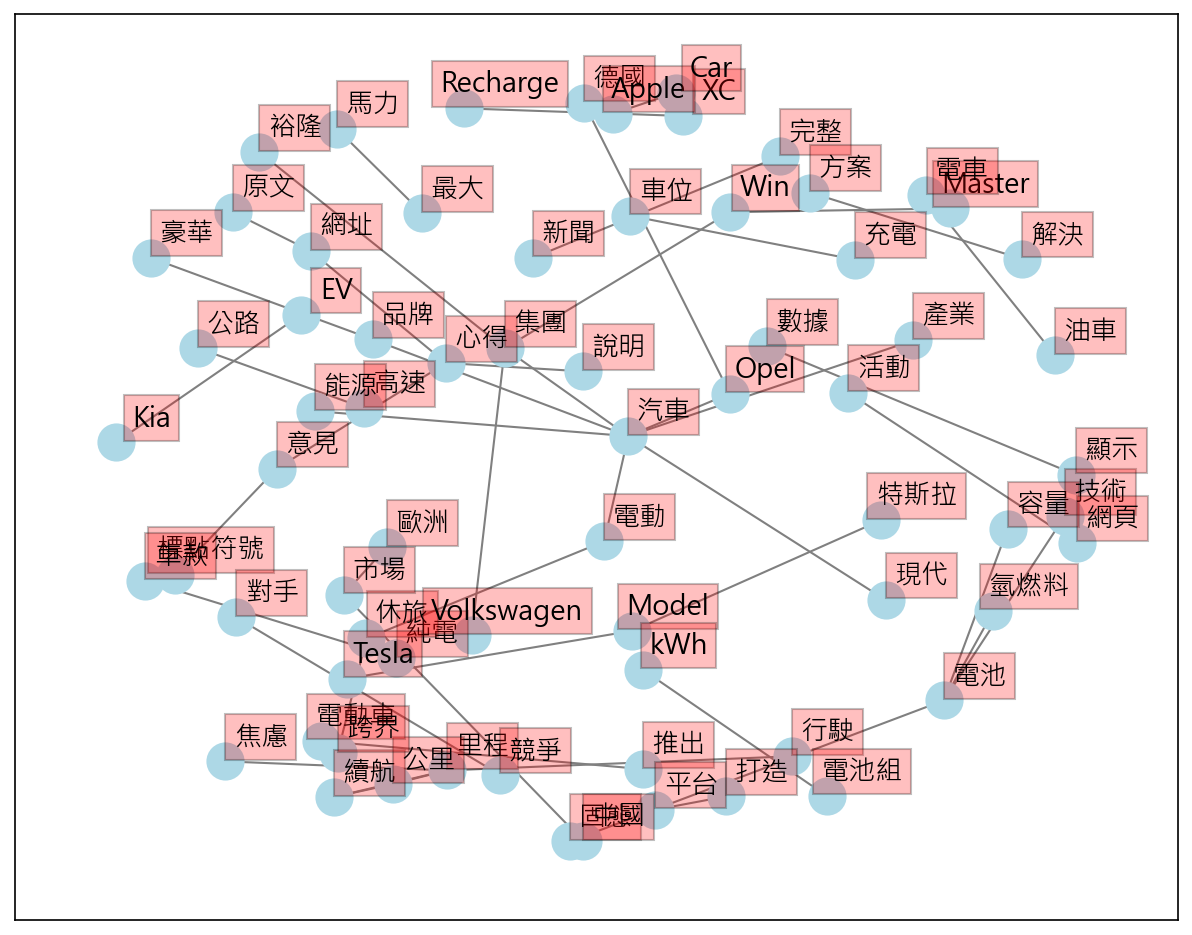

In [57]:
fig, ax = plt.subplots(figsize=(10, 8))
pos = nx.spring_layout(G, k=2)
fprop = fm.FontProperties(fname="./SourceHanSansTW-Regular.otf")
# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

民眾特別關注電動車的廠牌和電動車的充電電池。

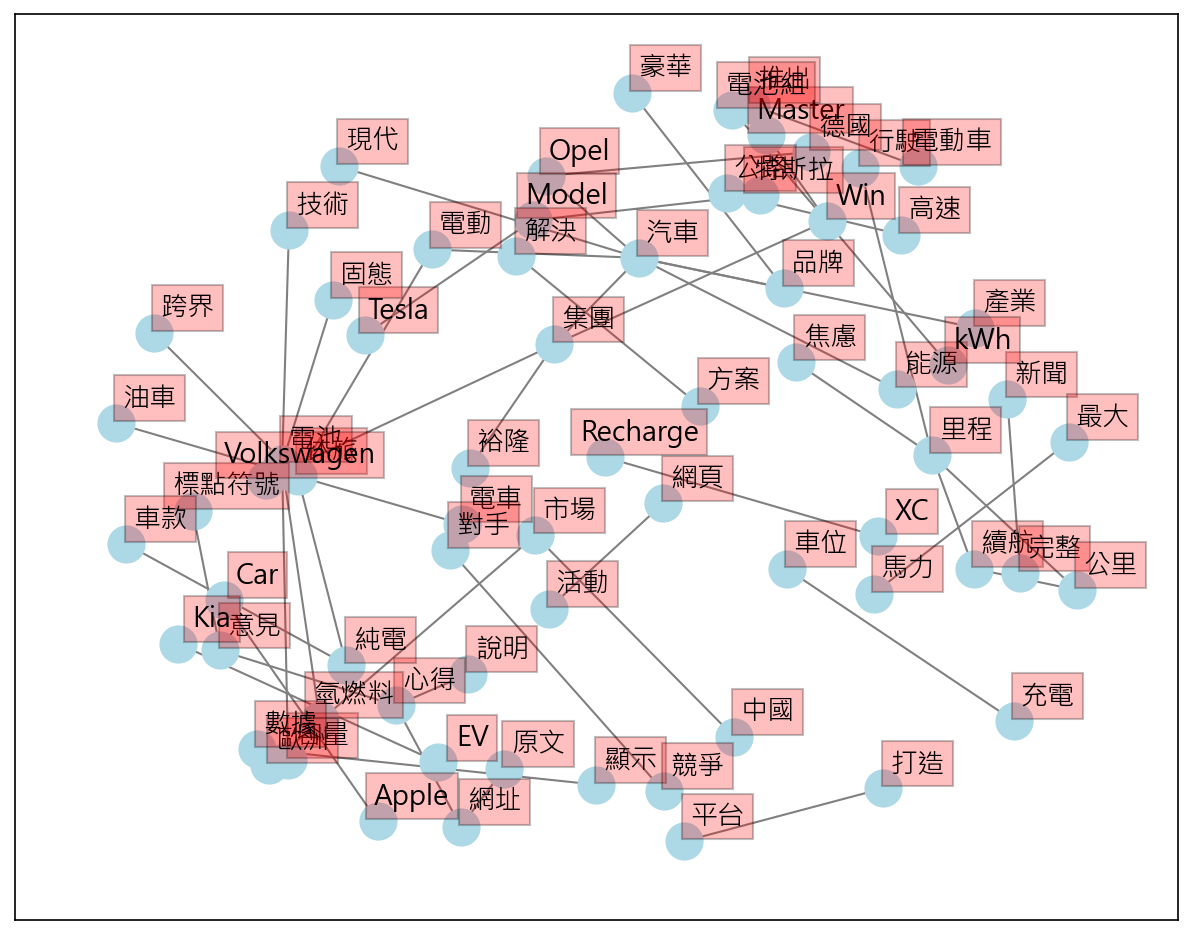

In [58]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()


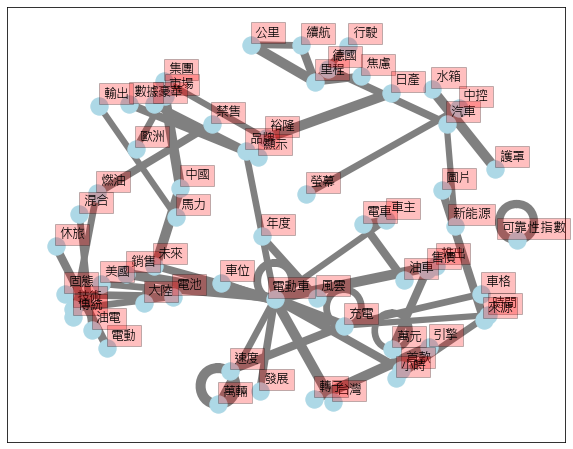

In [59]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [60]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from matplotlib import font_manager

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:

df = pd.read_csv("./car.csv")
df = df.rename(columns={"artContent": "sentence"})
df.head()

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/car/M.1648778137.A.72B....   
1          2  https://www.ptt.cc/bbs/car/M.1648821343.A.2E5....   
2          3  https://www.ptt.cc/bbs/car/M.1648894717.A.DDC....   
3          4  https://www.ptt.cc/bbs/car/M.1648907890.A.C6F....   
4          5  https://www.ptt.cc/bbs/car/M.1648953237.A.DDB....   

                  artTitle              artDate  artPoster artCatagory  \
0  [受訪]電動汽車充電行為與使用研究(徵受訪者)  2022-04-01 09:55:34      edian         car   
1      [電車]model31年半4萬公里花費  2022-04-01 21:55:39   mk203125         car   
2    Re:[討論]為什麼Model3越賣越好？  2022-04-02 18:18:33     asdhse         car   
3        [新聞]原材料短缺德國汽車產業驚恐  2022-04-02 21:58:07  yamatobar         car   
4        [問題]XC90退休後的通勤車選擇  2022-04-03 10:33:55  morrislek         car   

                                            sentence  \
0  本文經Munezsu板主核准\n各位Car版的版友好，\n\n我們是\nBLD\nEnerg...   
1  人生第一台車\n\n本來滿一年時想發個心得(花費)才發現第一年連保養里程都不到\n\n透天+...   
2  發這文，你後悔了嗎？\n現在入門要174萬惹，自從真特黑和假特粉都下去後，就沒有人可以阻止特...   
3  原文連結：\nhttps://reurl.cc/xOyGoN\n原文內容：\n\n（德國之聲...   
4  家裏的XC90（2018年式）即將屆滿五年，每日通勤車，目前里程數將近20萬公里，預計保固內...   

                                          artComment             e_ip  \
0                                                 []   61.227.169.165   
1  [{"cmtStatus": "推", "cmtPoster": "wuii0306", "...      1.34.96.153   
2  [{"cmtStatus": "推", "cmtPoster": "ISNAKEI", "c...  114.137.122.238   
3  [{"cmtStatus": "推", "cmtPoster": "iwei0930", "...   114.24.105.175   
4  [{"cmtStatus": "推", "cmtPoster": "Lowpapa", "c...   118.169.86.172   

          insertedDate dataSource  
0  2022-04-02 00:06:23        ptt  
1  2022-04-02 00:06:29        ptt  
2  2022-04-02 23:29:31        ptt  
3  2022-04-02 23:29:33        ptt  
4  2022-04-04 01:05:43        ptt

In [62]:
# 移除網址格式
# 只留下中文字
df["artComment"] = df["artComment"].str.replace("(http|https)://.*", "", regex=True)
df["artTitle"] = df["artTitle"].str.replace("(http|https)://.*", "", regex=True)
df["artComment"] = df["artComment"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
df["artTitle"] = df["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
df['content'] = df['artComment']


df = df.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
df.head(3)

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


content  \
0                                                      
1  推貓坐在前行李箱可愛推兩顆輪胎價格抵我的四顆還有找可怕推推推都給你們寫完就好了我也想發心得文...   
2  推是車版陳永仁推車板無間道推笑死我在年來最強反串推沒有人比你有資格嘴了推好扯用心良苦阿威當初...   

                                              artUrl artCatagory  \
0  https://www.ptt.cc/bbs/car/M.1648778137.A.72B....         car   
1  https://www.ptt.cc/bbs/car/M.1648821343.A.2E5....         car   
2  https://www.ptt.cc/bbs/car/M.1648894717.A.DDC....         car   

               artDate  
0  2022-04-01 09:55:34  
1  2022-04-01 21:55:39  
2  2022-04-02 18:18:33

In [63]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

df["words"] = df["content"].apply(getToken)
df.head()

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Building prefix dict from c:\Users\Modern 14\Desktop\SMA_G4project\SMA_G4project\20230605\dict\dict.txt ...
2023-06-05 20:13:02,362 : DEBUG : Building prefix dict from c:\Users\Modern 14\Desktop\SMA_G4project\SMA_G4project\20230605\dict\dict.txt ...
Loading model from cache C:\Users\MODERN~1\AppData\Local\Temp\jieba.u802bdb60760298ed0c9090505bd454e3.cache
2023-06-05 20:13:02,366 : DEBUG : Loading model from cache C:\Users\MODERN~1\AppData\Local\Temp\jieba.u802bdb60760298ed0c9090505bd454e3.cache
Loading model cost 1.818 seconds.
2023-06-05 20:13:04,182 : DEBUG : Loading model cost 1.818 seconds.
Prefix dict has be

content  \
0                                                      
1  推貓坐在前行李箱可愛推兩顆輪胎價格抵我的四顆還有找可怕推推推都給你們寫完就好了我也想發心得文...   
2  推是車版陳永仁推車板無間道推笑死我在年來最強反串推沒有人比你有資格嘴了推好扯用心良苦阿威當初...   
3  推真的戰爭還是要用油車逃吧電車能跑多遠推又來了賣不好就怪東怪西銷量被牌海放噓讚又可以再漲個五...   
4  推推可以等新看看推五年萬真猛推很正常的里程車就是要這樣開但是怎麼一直有傳動軸的問題樓主保養都...   

                                              artUrl artCatagory  \
0  https://www.ptt.cc/bbs/car/M.1648778137.A.72B....         car   
1  https://www.ptt.cc/bbs/car/M.1648821343.A.2E5....         car   
2  https://www.ptt.cc/bbs/car/M.1648894717.A.DDC....         car   
3  https://www.ptt.cc/bbs/car/M.1648907890.A.C6F....         car   
4  https://www.ptt.cc/bbs/car/M.1648953237.A.DDB....         car   

               artDate                                              words  
0  2022-04-01 09:55:34                                                 []  
1  2022-04-01 21:55:39  [推貓, 行李箱, 可愛, 推兩顆, 輪胎, 價格, 四顆, 可怕, 推推, 推都給, 寫完...  
2  2022-04-02 18:18:33  [推是, 車版, 陳永仁, 推車, 無間, 笑死, 最強, 反串, 人比, 資格, 好扯, ...  
3  2022-04-02 21:58:07  [戰爭, 用油, 車逃, 電車, 又來了, 怪東怪西, 銷量, 牌海放, 漲個, 五萬, 笑...  
4  2022-04-03 10:33:55  [推推, 看看, 五年, 萬真, 猛推, 正常, 里程, 傳動軸, 問題, 樓主, 保養, ...

In [64]:
custom_topic_word = {
    "廠牌": [
        "裕隆",
        "特斯拉",
        "TESLA",
        "球團",
    ],
    "規格": [
        "配息",
        "金融",
        "聯準會",
        "買超",
        "債券",
        "動能",
        "下跌",
        "漲幅",
    ],
    "性能": [
        "電子",
        "半導體",
        "能源",
        "布局",
        "科技",
        "電動車",
        "智慧",
        "鴻海",
        " 品牌",
        "網路",
    ],
    "兩岸": [
        "華為",
        "政協",
        "兩會",
    ],
    "全球": [
        "美國",
    ],
}

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# LDA

In [68]:
docs = df['words'].to_list()
docs[1]

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['推貓',
 '行李箱',
 '可愛',
 '推兩顆',
 '輪胎',
 '價格',
 '四顆',
 '可怕',
 '推推',
 '推都給',
 '寫完',
 '好了',
 '想發',
 '心得',
 '文阿賣',
 '綠電',
 '羨慕',
 '綠電',
 '推讚',
 '條件',
 '電車',
 '真好',
 '太陽能版',
 '要設',
 '台中',
 '以南',
 '效率',
 '推越',
 '開越',
 '便宜',
 '休旅',
 '皮卡',
 '房車',
 '式微',
 '推什麼',
 '推靠',
 '規格',
 '台中',
 '馳加',
 '換顆',
 '兩萬出',
 '台電',
 '收一度',
 '推賣電',
 '回去',
 '挖礦',
 '同期',
 '交車',
 '換一次',
 '輪胎',
 '萬萬',
 '保養',
 '一次',
 '兩次加',
 '四千有',
 '換次',
 '甘蔗板',
 '左右',
 '換兩次',
 '濾網',
 '內一次',
 '雨刷',
 '算個',
 '超速',
 '罰單',
 '最大',
 '開銷',
 '再家',
 '充電',
 '平均',
 '兩個',
 '每月',
 '里程',
 '萬是',
 '里程',
 '罰單']

In [69]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 20 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2023-06-05 20:16:17,073 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-06-05 20:16:17,930 : INFO : built Dictionary<40065 unique tokens: ['一次', '交車', '以南', '休旅', '便宜']...> from 995 documents (total 295038 corpus positions)
2023-06-05 20:16:17,940 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<40065 unique tokens: ['一次', '交車', '以南', '休旅', '便宜']...> from 995 documents (total 295038 corpus positions)", 'datetime': '2023-06-05T20:16:17.938344', 'gensim': '4.3.1', 'python': '3.9.4 (tags/v3.9.4:1f2e308, Apr  6 2021, 13:40:21) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0

Dictionary<6919 unique tokens: ['一次', '交車', '休旅', '便宜', '保養']...>


In [70]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一次: 0
交車: 1
休旅: 2
便宜: 3
保養: 4
價格: 5
充電: 6
兩個: 7
可怕: 8
可愛: 9
台中: 10
台電: 11


C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
pprint(" ".join(df['words'].iloc[600]))


(

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'印象 輪框 很帥 推帥 離不開 吉利 電車 架構 推好 十字 只服 領克極 沃爾 沃極星 魔術 空間 第二個 杯架 中央 扶手 往後 後座 中間 位子 '
 '沒辦法 坐人 廢到 台灣 變天 修法 中國 車惹 推開 特斯拉 問題 台灣 開放 中國 車對 特斯拉 利多')


In [72]:
dictionary.doc2bow(df['words'].iloc[600])[:10]

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(46, 1),
 (92, 2),
 (123, 2),
 (176, 1),
 (205, 1),
 (282, 1),
 (553, 1),
 (638, 1),
 (1107, 2),
 (1184, 1)]

In [73]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=4, # 生成幾個主題數
    random_state=2021, # 亂數
)

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2023-06-05 20:16:19,301 : INFO : using symmetric alpha at 0.25
2023-06-05 20:16:19,303 : INFO : using symmetric eta at 0.25
2023-06-05 20:16:19,309 : INFO : using serial LDA version on this node
2023-06-05 20:16:19,319 : INFO : running online (single-pass) LDA training, 4 topics, 1 passes over the supplied corpus of 995 documents, updating model once every 995 documents, evaluating perplexity every 995 documents, iterating 50x with a convergence threshold of 0.001000
2023-06-05 20:16:19,321 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve 

In [75]:
ldamodel.print_topics()

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2023-06-05 20:16:25,024 : INFO : topic #0 (0.250): 0.017*"台灣" + 0.014*"電動車" + 0.013*"電車" + 0.010*"充電" + 0.009*"特斯拉" + 0.009*"油車" + 0.008*"電池" + 0.008*"問題" + 0.006*"現在" + 0.005*"車主"
2023-06-05 20:16:25,027 : INFO : topic #1 (0.250): 0.023*"電車" + 0.015*"特斯拉" + 0.013*"充電" + 0.010*"台灣" + 0.010*"油車" + 0.007*"推推" + 0.007*"問題" + 0.006*"現在" + 0.006*"電池" + 0.006*"電動車"
2023-06-05 20:16:25,030 : INFO : topic #2 (0.250): 0.019*"電車" + 0.013*"充電" + 0.012*"特斯拉" + 0.011*"油車" + 0.009*"電池" + 0.009*"台灣" + 0.008*"電動車" + 0.008*"問題" + 0.008*"現在" + 0.004*"笑死"
2023-06-05 20:16:25,032 : INFO : topic #3 (0.250): 0.013*"電車" + 0.013*"電池" + 

[(0,
  '0.017*"台灣" + 0.014*"電動車" + 0.013*"電車" + 0.010*"充電" + 0.009*"特斯拉" + 0.009*"油車" + 0.008*"電池" + 0.008*"問題" + 0.006*"現在" + 0.005*"車主"'),
 (1,
  '0.023*"電車" + 0.015*"特斯拉" + 0.013*"充電" + 0.010*"台灣" + 0.010*"油車" + 0.007*"推推" + 0.007*"問題" + 0.006*"現在" + 0.006*"電池" + 0.006*"電動車"'),
 (2,
  '0.019*"電車" + 0.013*"充電" + 0.012*"特斯拉" + 0.011*"油車" + 0.009*"電池" + 0.009*"台灣" + 0.008*"電動車" + 0.008*"問題" + 0.008*"現在" + 0.004*"笑死"'),
 (3,
  '0.013*"電車" + 0.013*"電池" + 0.009*"特斯拉" + 0.009*"油車" + 0.009*"充電" + 0.008*"現在" + 0.008*"台灣" + 0.008*"電動車" + 0.006*"問題" + 0.005*"推推"')]

In [76]:
ldamodel.get_document_topics(corpus[0])

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.25), (1, 0.25), (2, 0.25), (3, 0.25)]

In [77]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2023-06-05 20:16:28,759 : INFO : -7.957 per-word bound, 248.5 perplexity estimate based on a held-out corpus of 995 documents with 240817 words


-7.95727577839265

In [78]:
np.exp2(-perplexity)

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


248.52992746271443

In [79]:
# pmi
PMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2023-06-05 20:16:29,102 : INFO : using ParallelWordOccurrenceAccumulator<processes=7, batch_size=64> to estimate probabilities from sliding windows
2023-06-05 20:16:41,357 : INFO : 1 batches submitted to accumulate stats from 64 documents (14180 virtual)
2023-06-05 20:16:41,368 : INFO : 2 batches submitted to accumulate stats from 128 documents (36711 virtual)
2023-06-05 20:16:41,378 : INFO : 3 batches submitted to accumulate stats from 192 documents (53078 virtual)
2023-06-05 20:16:41,395 : INFO : 4 batches submitted to accumulate stats from 256 documents (74672 virtual)
2023-06-05 20:16:41,440 : INFO : 5 batche

這個主題的 PMI score:  -0.013127058787837148


這個主題的 PMI score:  -0.013127

In [80]:
PMI_model_lda.get_coherence_per_topic()

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[-0.014322210361437604,
 -0.014068885060835378,
 -0.011347674270526704,
 -0.012769465458548908]

每個topic 的coherence[-0.014322210361437604,
 -0.014068885060835378,
 -0.011347674270526704,
 -0.012769465458548908]

In [81]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2023-06-05 20:16:44,851 : INFO : using symmetric alpha at 0.5
2023-06-05 20:16:44,854 : INFO : using symmetric eta at 0.5
2023-06-05 20:16:44,860 : INFO : using serial LDA version on this node
2023-06-05 20:16:44,865 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 995 documents, updating model once every 995 documents, evaluating perplexity every 995 documents, iterating 50x with a convergence threshold of 0.001000
2023-06-05 20:16:44,866 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve acc

花費時間: 308.40398383140564 sec


In [82]:
result = pd.DataFrame(result)
result

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_num   perplexity       pmi
0          2  2422.298400 -0.012097
1          3  2347.504694 -0.004160
2          4  2398.821526 -0.000056
3          5  2400.937915 -0.002020
4          6  2437.126504 -0.002867
5          7  2497.780089 -0.003278
6          8  2540.930735 -0.007910
7          9  2554.095784 -0.001587

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='topic_num'>

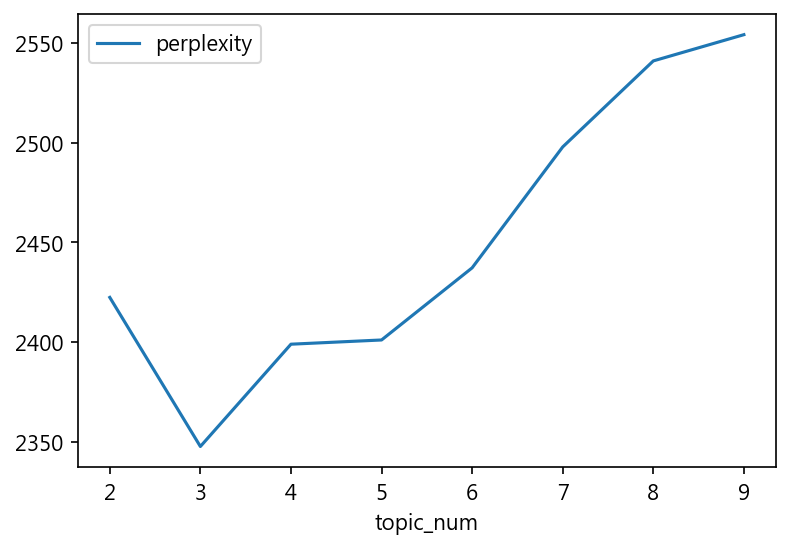

In [83]:
result.plot.line(x='topic_num', y='perplexity')

topic 的perplexity 為3


C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='topic_num'>

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


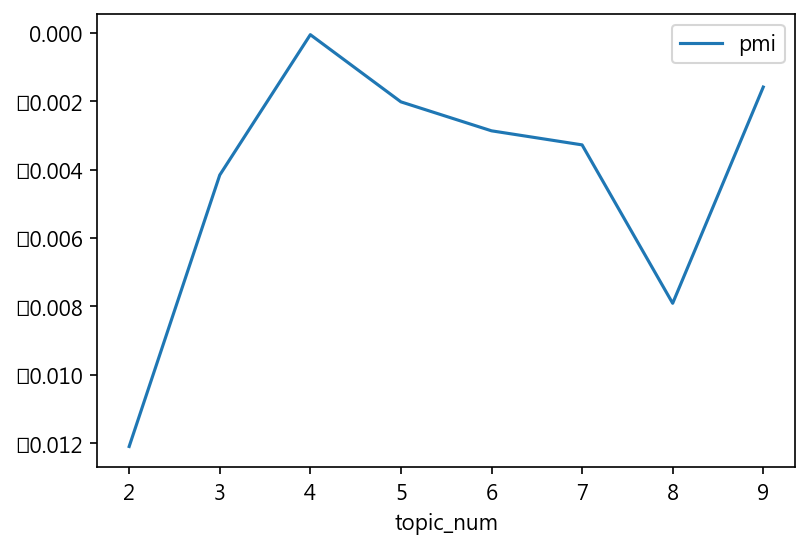

In [84]:
result.plot.line(x='topic_num', y='pmi')

topic 的PMI為4 選擇3或4個主題都行，但因內容較重複的關係，我們選擇3個主題

In [85]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 3,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2023-06-05 20:21:54,624 : INFO : using symmetric alpha at 0.3333333333333333
2023-06-05 20:21:54,627 : INFO : using symmetric eta at 0.3333333333333333
2023-06-05 20:21:54,632 : INFO : using serial LDA version on this node
2023-06-05 20:21:54,639 : INFO : running online (multi-pass) LDA training, 3 topics, 5 passes over the supplied corpus of 995 documents, updating model once every 995 documents, evaluating perplexity every 995 documents, iterating 50x with a convergence threshold of 0.001000
2023-06-05 20:21:54,641 : WARNING : too few updates, training might not converge; consider increasing the number of passe

In [86]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.006752 -0.053089       1        1  33.876884
0     -0.058802  0.030869       2        1  33.196741
2      0.065554  0.022220       3        1  32.926374, topic_info=    Term         Freq        Total Category  logprob  loglift
6     充電  2709.000000  2709.000000  Default  30.0000  30.0000
46    電車  4185.000000  4185.000000  Default  29.0000  29.0000
22    推推  1052.000000  1052.000000  Default  28.0000  28.0000
90    油車  2317.000000  2317.000000  Default  27.0000  27.0000
529   電池  2017.000000  2017.000000  Default  26.0000  26.0000
..   ...          ...          ...      ...      ...      ...
270   直接   250.477943   717.526788   Topic3  -5.7575   0.0585
529   電池   255.619668  2017.107897   Topic3  -5.7372  -0.9548
246   樓上   188.458037   452.365909   Topic3  -6.0420   0.2353
3     便宜   187.390416   657.504033   Topic3  -6.0477  -0.1444
443   本來   170.946396   417.650538   Topic3  -6.1395   0.2176

[276 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2210      1  0.824704   上天
2210      2  0.117815   上天
141       1  0.277722   不用
141       2  0.299011   不用
141       3  0.423841   不用
...     ...       ...  ...
3346      2  0.934877   麗寶
3346      3  0.046744   麗寶
3545      1  0.020513   黑絲
3545      2  0.882079   黑絲
3545      3  0.102567   黑絲

[615 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [87]:
pyLDAvis.save_html(p, "lda_zh.html")

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


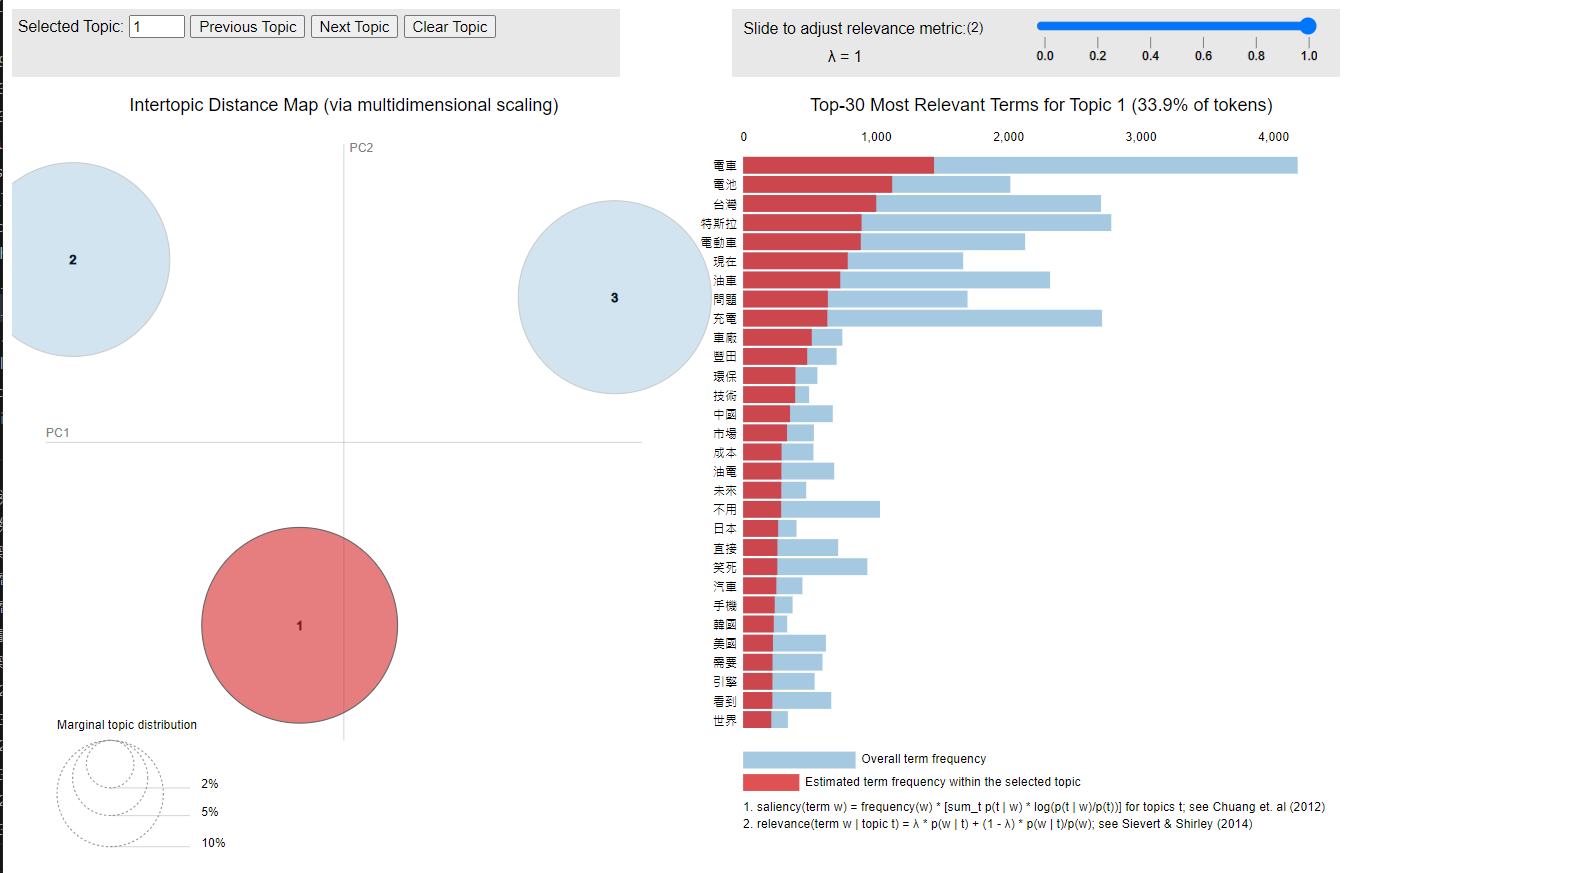

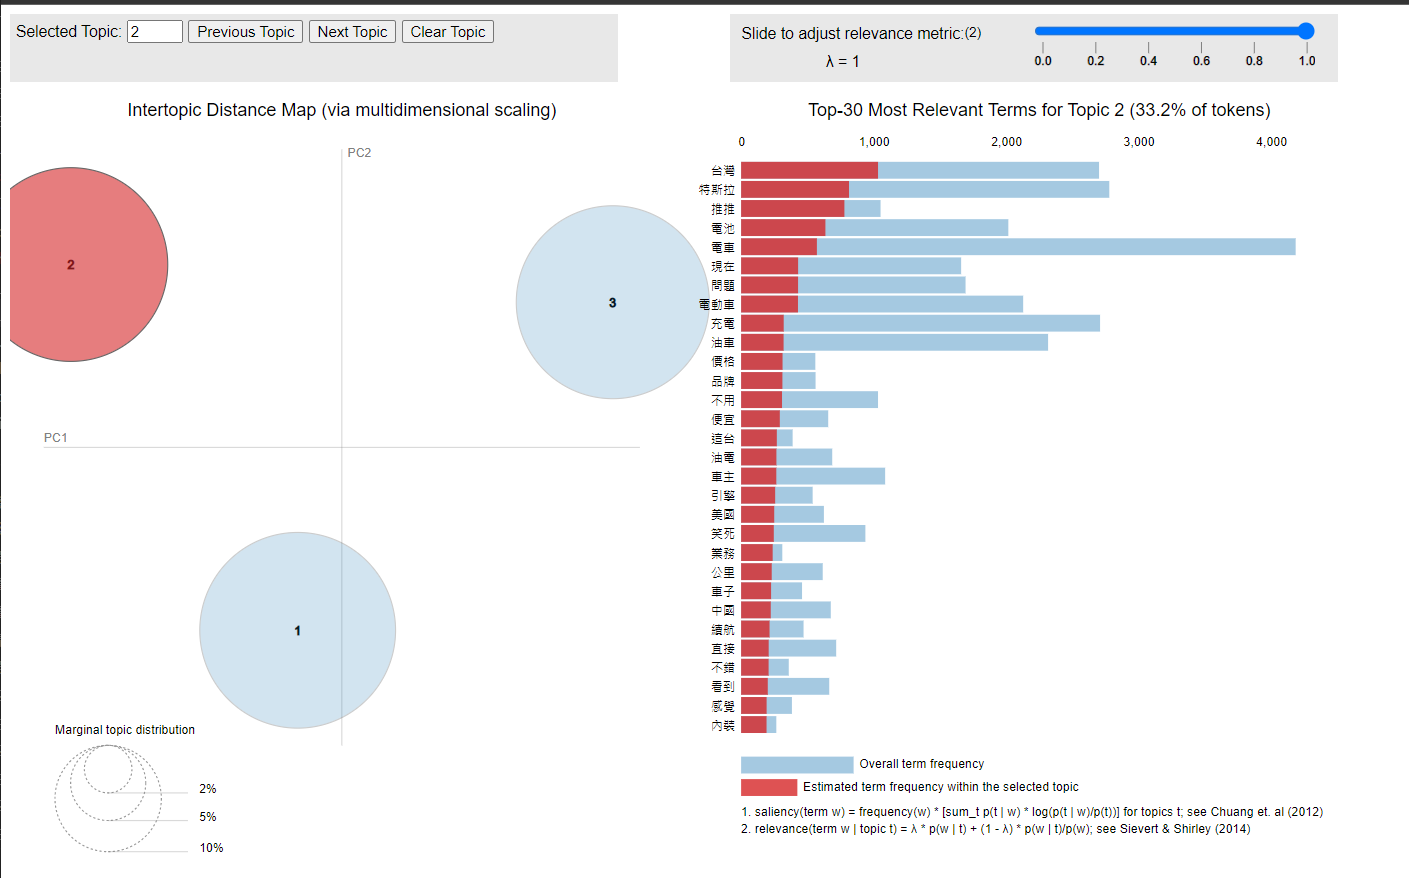

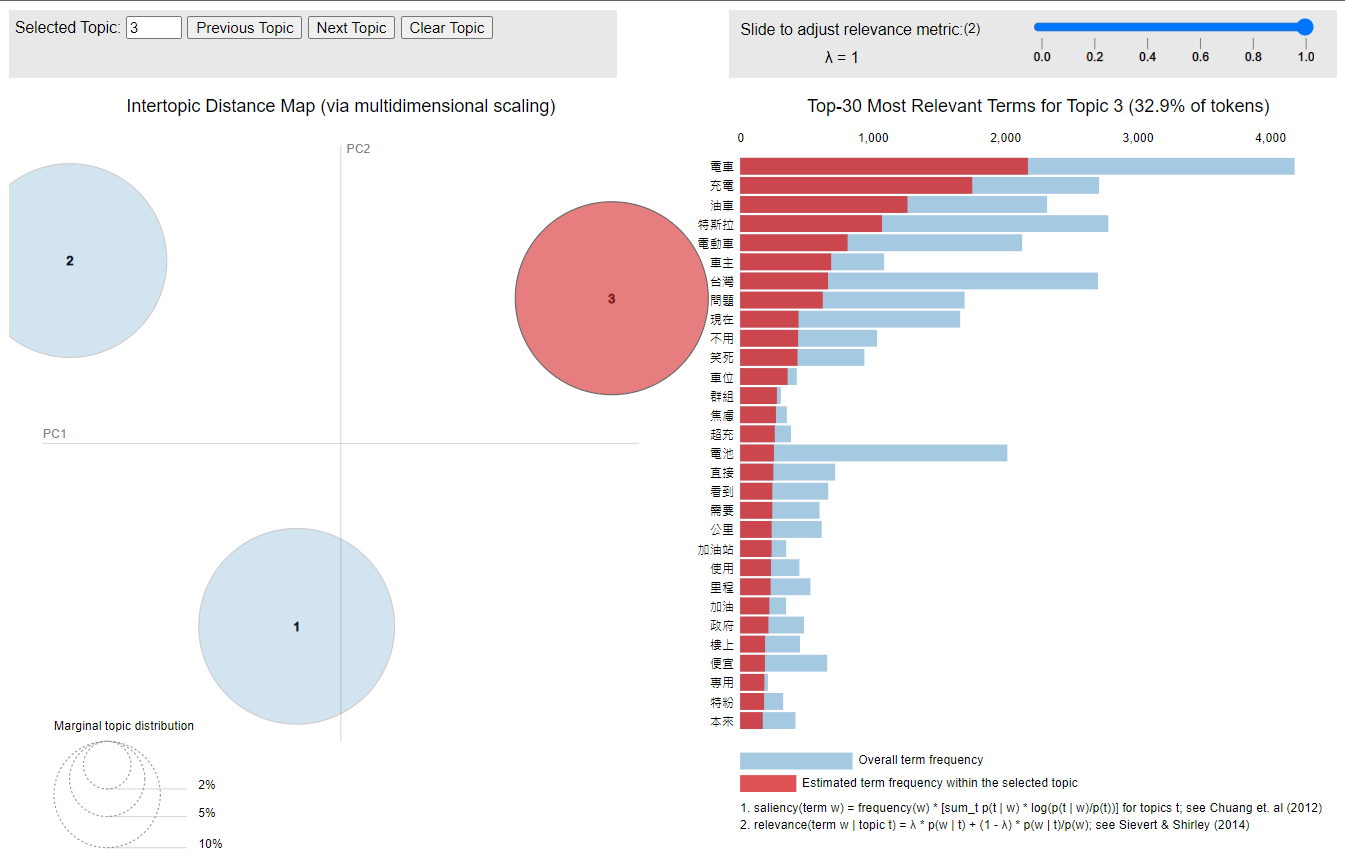

In [88]:
! pip install pyvis networkx pandas numpy

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
import pandas as pd
import numpy as np
import pyvis
import networkx as nx
import IPython

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


整個6月的資料量太大，所以下方改為使用colab連線執行結果

In [90]:
from google.colab import drive
drive.mount('/content/drive')
raw_data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/car_June.csv')
raw_data = raw_data[raw_data.artComment != '[]']
# raw_data = raw_data.sample(round(raw_data.shape[0]/4))
# print(raw_data.shape)
raw_data.head()

C:\Users\Modern 14\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
#parse comment

def getComtInfo(com):
  cmters,cmt_statuss = [],[]
  com = eval(com)
  for i in com:
    print(i)
    cmters.append(i['cmtPoster'])
    cmt_statuss.append(i['cmtStatus'])
  return pd.Series([cmters, cmt_statuss])

raw_data[['artComter','artStatus']] = raw_data['artComment'].apply(lambda r: getComtInfo(r))

In [ ]:
raw_data = raw_data.explode(['artComter','artStatus'])
socail_data = raw_data[['artUrl','artPoster','artComter','artStatus']]
socail_data.head(10)

In [ ]:
socail_data.artStatus.unique()

In [ ]:
# 建立邊的資料
import random


po_df = socail_data[['artPoster','artUrl']].drop_duplicates().rename(columns = {'artPoster':'src','artUrl':'dis'})
sample_url = random.choices(po_df.dis.unique().tolist(),k=300)
po_df = po_df[po_df.dis.isin(sample_url)]
re_df = socail_data[['artComter','artUrl','artStatus']].rename(columns = {'artComter':'src','artUrl':'dis','artStatus':'weight'})
re_df = re_df[re_df.dis.isin(sample_url)]
re_df = re_df[~re_df['src'].isna()]



def convertStatus(s):
  if s == '推':
    return 2
  elif s == '→':
    return 1
  else :
    return -1
re_df['weight'] = re_df['weight'].map(convertStatus)
re_df = re_df.groupby(['src','dis']).sum().reset_index()

# 設定分數低的為紅色
def getColor(w):
  if w>0:
    return 'green'
  else:
    return 'red'
re_df['color'] = re_df.weight.map(getColor)

In [ ]:
re_df

In [ ]:
# 人為綠色節點
# po文為橘色節點

netWork = pyvis.network.Network(notebook=True, cdn_resources='in_line',directed=True)
person = list(set(po_df.src.unique().tolist()+re_df.src.unique().tolist()))
url = po_df.dis.unique().tolist()
netWork.add_nodes(
    nodes = person,
    value = [1 for i in range(len(person))],
    color = ['#66CDAA' for i in range(len(person))],
    title = person
)
netWork.add_nodes(
    nodes = url,
    value = [2 for i in range(len(url))],
    color = ['#FFB366' for i in range(len(url))],
    title = url
)
for i in po_df.to_numpy():
  netWork.add_edge(i[0],i[1],width = 2,color='grey')
for i in re_df.to_numpy():
  netWork.add_edge(i[0],i[1],width = 2,color=i[3])

# 設定layout
netWork.repulsion()

# netWork.toggle_physics(True)
# netWork.set_options("""
# const options = {
#   "physics": {
#     "forceAtlas2Based": {
#       "springLength": 100
#     },
#     "minVelocity": 0.75,
#     "solver": "forceAtlas2Based",
#     "timestep": 0.48
#   }
# }
# """)

netWork.show("./basic_netWork.html")
IPython.display.HTML('basic_netWork.html')

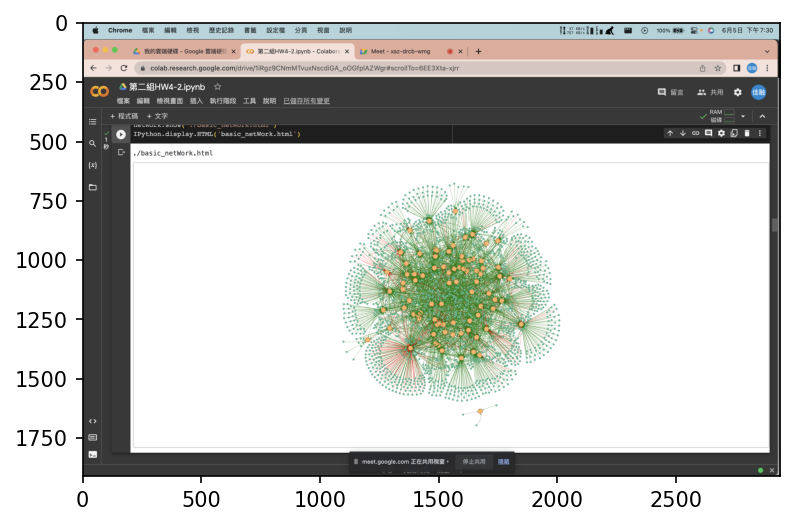

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
image = img.imread('socialNetwork.png')                       # 讀取圖片
plt.imshow(image)                                    # 在圖表中繪製圖片
plt.show()  

<h4>因為我們的資料集來自ptt的汽車版，並從中篩選出來電動車相關主題，
<br>所以可以看到社群網路圖跑出來的圖為集中在一起的情況，
<br>討論的議題並沒有向其他討論版一樣發散(很多小群集)。</h4>

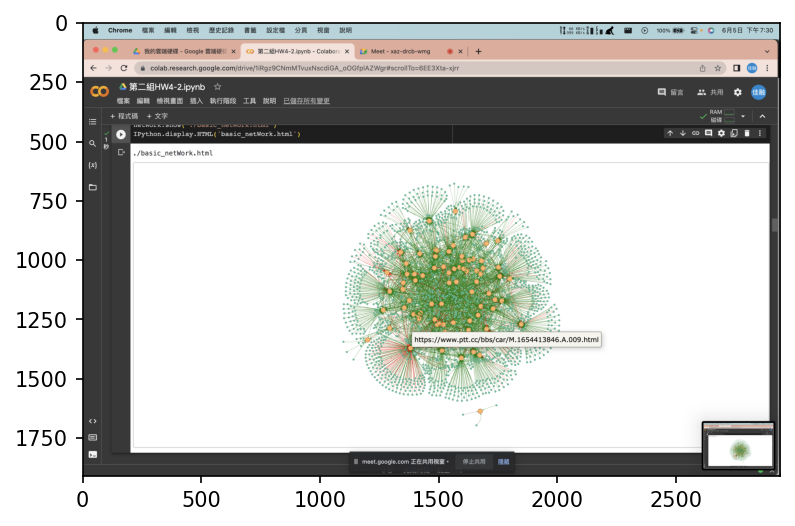

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
image = img.imread('A_009.png')                       # 讀取圖片
plt.imshow(image)                                    # 在圖表中繪製圖片
plt.show()  

此篇文章為特斯拉男因充電樁問題對其他使用者開槍，導致許多負面言論，故本研究推論在六月的期間會出現大量負面文字可能有大多關係和此文章有相關，在此研究中找出較為特別的議題

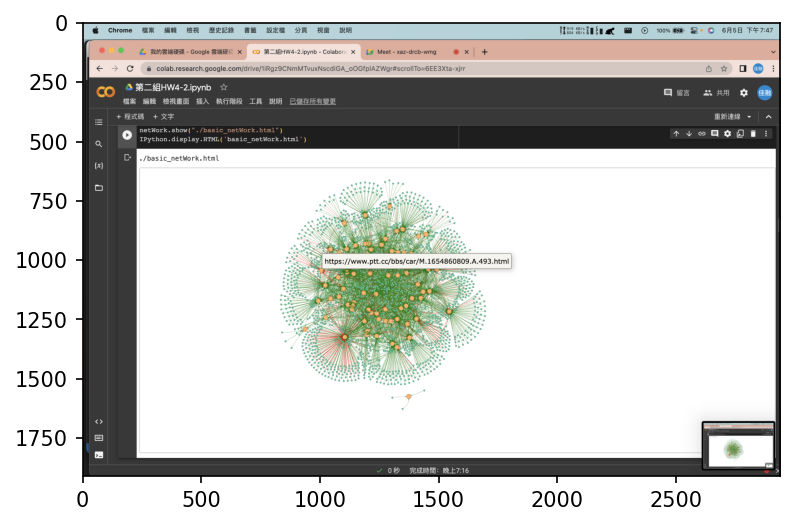

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
image = img.imread('A_493.png')                       # 讀取圖片
plt.imshow(image)                                    # 在圖表中繪製圖片
plt.show()  

A.493 文不對題，自以為有趣，發錯版，亦或者這個人覺得好玩想引起關注，故發出此文章，以自娛娛人的方式尋求關注，但和電動車議題無過多相關

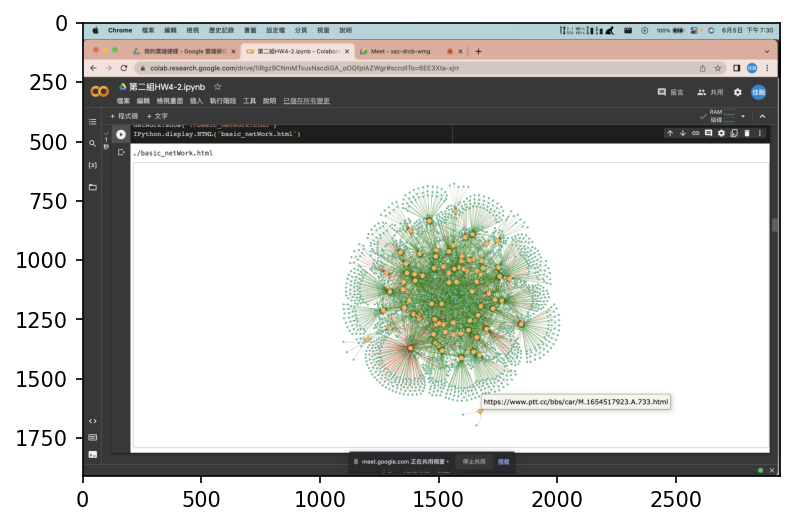

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
image = img.imread('A_733.png')                       # 讀取圖片
plt.imshow(image)                                    # 在圖表中繪製圖片
plt.show()  

對於這個與其他點分開的點，我們去做調查後可以做以下解釋：
<div>1.這篇貼文的主題以及內容僅僅在分享版主在駕駛電動車以及電動滑板的遊記，對於其他用戶是不感興趣因此回覆的人相當的少</div>
<br> 
<div>2.因為這篇貼文回覆人數相當的少，以及有回覆這篇貼文的用戶在六月期間是沒有回覆其他篇貼文的。</div>

因此綜合以上兩點可以知道為何這個點被孤立在一旁